In [45]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import pickle
import scipy.io as spio

import replay_structure.metadata as meta
import replay_structure.read_write as read_write
from replay_structure.utils import get_marginal_sum, get_p_models

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import replay_structure.structure_models as models

from replay_structure.metadata import (
    Likelihood_Function,
    Model,
    Diffusion,
    Momentum,
    Stationary,
    Stationary_Gaussian,
    Random,
    Data_Type,
    string_to_data_type,
    string_to_model,
    Session_Indicator,
    string_to_session_indicator,
    string_to_likelihood_function,
)

In [48]:
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('font', size=SMALL_SIZE, family='sans-serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=2, color='r')
plt.rcParams['font.sans-serif'] = ['Helvetica']

## raw data

In [49]:
path = '../data/'

In [50]:
matlab_struct = spio.loadmat(path+'OpenFieldData.mat', squeeze_me=True, struct_as_record=False)

In [51]:
raw_data11 = matlab_struct["Data"].Rat1.Day1

In [14]:
raw_data11.PositionData

array([[2572.2150173 ,   30.37142009,  173.68073961,  222.94030343],
       [2572.2305895 ,   30.85327657,  173.97282001,  224.9103587 ],
       [2572.2639561 ,   31.24682017,  174.22647284,  221.10268052],
       ...,
       [4860.1495621 ,   23.72754433,   13.53910145,  219.29904198],
       [4860.1829288 ,   24.12866361,   14.00912848,  220.89866875],
       [4860.2162955 ,   24.54617006,   14.44350487,  225.07679459]])

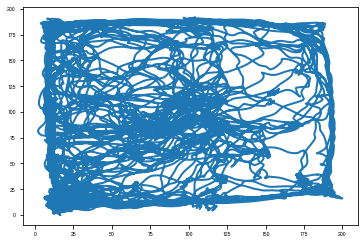

In [15]:
plt.plot(raw_data11.PositionData[:,1], raw_data11.PositionData[:,2])

In [10]:
raw_data11.SpikeData

array([[2.57200220e+03, 2.10000000e+01],
       [2.57200263e+03, 9.70000000e+01],
       [2.57200521e+03, 1.41000000e+02],
       ...,
       [4.75899208e+03, 5.00000000e+00],
       [4.75899346e+03, 3.00000000e+00],
       [4.75899783e+03, 1.34000000e+02]])

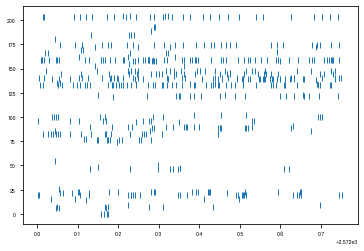

In [11]:
plt.plot(raw_data11.SpikeData[:500,0], raw_data11.SpikeData[:500,1].astype(int)-1, '|')

In [34]:
data = dict()
data["significant_ripples"] = raw_data11.SignificantRipples-1
data["ripple_info"] = raw_data11.RippleTimes
data["inhibitory_neurons"] = (np.array(raw_data11.InhibitoryNeurons) - 1)  # account for matlab indexing
data["excitatory_neurons"] = (raw_data11.ExcitatoryNeurons - 1)  # account for matlab indexing
data["well_locations"] = raw_data11.WellLocations
data["well_sequence"] = raw_data11.WellSequence
data["spike_ids"] = raw_data11.SpikeData[:, 1].astype(int) - 1
data["spike_times_s"] = raw_data11.SpikeData[:, 0]
data["pos_times_s"] = raw_data11.PositionData[:, 0]
data["pos_xy_cm"] = np.squeeze(raw_data11.PositionData[:, 1:-1])
data["ripple_times_s"] = data["ripple_info"][:, :2]
data["n_ripples"] = len(data["ripple_times_s"])
data["n_cells"] = np.max(data["spike_ids"] + 1)

In [37]:
data["pos_xy_cm"]

array([[ 30.37142009, 173.68073961],
       [ 30.85327657, 173.97282001],
       [ 31.24682017, 174.22647284],
       ...,
       [ 23.72754433,  13.53910145],
       [ 24.12866361,  14.00912848],
       [ 24.54617006,  14.44350487]])

In [29]:
data["spike_times_s"]

array([2572.002195, 2572.002625, 2572.005206, ..., 4758.99208 ,
       4758.993463, 4758.997825])

In [30]:
data["spike_ids"]

array([ 20,  96, 140, ...,   4,   2, 133])

In [25]:
data["significant_ripples"]

array([  7,   8,  10,  11,  12,  13,  15,  19,  23,  27,  29,  33,  34,
        37,  39,  41,  42,  49,  50,  52,  54,  63,  71,  74,  76,  79,
        96,  97, 104, 110, 113, 117, 123, 125, 127, 135, 150, 151, 154,
       156, 159, 160, 162, 167, 168, 169, 175, 177, 180, 183, 186, 187,
       195, 198, 208, 209, 210, 216, 217, 218, 219, 220, 227, 228, 231,
       232, 233, 235, 238, 242, 244, 246, 248, 250, 258, 263, 269, 271,
       274, 276, 277, 279, 283, 287, 291, 299, 300, 305, 310, 312, 316,
       317, 318], dtype=uint16)

In [26]:
data["ripple_times_s"][:20]

array([[2671.74680952, 2671.97075822],
       [2676.98641271, 2677.10069097],
       [2696.0036285 , 2696.32127349],
       [2700.93664655, 2701.15844439],
       [2701.60818543, 2701.69665937],
       [2704.19634546, 2704.37329221],
       [2707.00261733, 2707.08679013],
       [2777.37967975, 2777.55078993],
       [2781.75297883, 2781.92501139],
       [2904.09107791, 2904.26249589],
       [2908.37682521, 2908.70767977],
       [2944.62980468, 2944.73671054],
       [2945.08200281, 2945.33820761],
       [2945.90161254, 2946.19437425],
       [2948.28671343, 2948.41420139],
       [2982.50879368, 2982.78711624],
       [2983.65464935, 2983.78029425],
       [2997.72533063, 2997.88783997],
       [2998.4269756 , 2998.5833405 ],
       [3035.66084471, 3035.83902062]])

In [27]:
data["ripple_info"][:20]

array([[2671.74680952, 2671.97075822, 2671.8202306 ],
       [2676.98641271, 2677.10069097, 2677.06198387],
       [2696.0036285 , 2696.32127349, 2696.20853138],
       [2700.93664655, 2701.15844439, 2701.11328611],
       [2701.60818543, 2701.69665937, 2701.65641601],
       [2704.19634546, 2704.37329221, 2704.32782673],
       [2707.00261733, 2707.08679013, 2707.04746841],
       [2777.37967975, 2777.55078993, 2777.50962502],
       [2781.75297883, 2781.92501139, 2781.88108165],
       [2904.09107791, 2904.26249589, 2904.17862997],
       [2908.37682521, 2908.70767977, 2908.6542271 ],
       [2944.62980468, 2944.73671054, 2944.69032331],
       [2945.08200281, 2945.33820761, 2945.15204468],
       [2945.90161254, 2946.19437425, 2946.03923823],
       [2948.28671343, 2948.41420139, 2948.33801598],
       [2982.50879368, 2982.78711624, 2982.60064625],
       [2983.65464935, 2983.78029425, 2983.719776  ],
       [2997.72533063, 2997.88783997, 2997.81472617],
       [2998.4269756 , 2998.

In [24]:
data["spike_times_s"]

array([2572.002195, 2572.002625, 2572.005206, ..., 4758.99208 ,
       4758.993463, 4758.997825])

In [35]:
spikes_before_position_recording=data["spike_times_s"]<data["pos_times_s"][0]

spikes_after_position_recording=data["spike_times_s"]>data["pos_times_s"][-1]

spike_ids_aligned_to_position_recording = data["spike_ids"][
            ~spikes_before_position_recording & ~spikes_after_position_recording]
spike_ids_aligned_to_position_recording.shape

In [38]:
position_before_spikes_recording = data["pos_times_s"] < data["spike_times_s"][0]
position_after_spikes_recording = data["pos_times_s"] > data["spike_times_s"][-1]
pos_xy_aligned_to_spikes_recording = data["pos_xy_cm"][
            ~position_before_spikes_recording & ~position_after_spikes_recording
        ]
pos_times_aligned_to_spikes_recording = data["pos_times_s"][
            ~position_before_spikes_recording & ~position_after_spikes_recording
        ]

## preprocessed data

In [6]:
session = meta.Session_List[0]
rd = read_write.load_ratday_data(session)

loading  /home/katharina/Documents/Studium/MIT/project/data/ratday/rat1day1_4cm.obj


In [7]:
rd.data.keys()

dict_keys(['significant_ripples', 'ripple_info', 'inhibitory_neurons', 'excitatory_neurons', 'well_locations', 'well_sequence', 'spike_ids', 'spike_times_s', 'pos_times_s', 'pos_xy_cm', 'ripple_times_s', 'n_ripples', 'n_cells', 'large_position_gaps_inds'])

In [8]:
rd.place_field_data.keys()

dict_keys(['run_data', 'spatial_grid', 'position_histogram', 'spike_histograms', 'place_fields', 'place_fields_likelihood', 'mean_firing_rate_array', 'max_firing_rate_array', 'excitatory_neurons', 'inhibitory_neurons', 'place_cell_ids', 'n_place_cells'])

In [16]:
rd.place_field_data['place_cell_ids']

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       134, 135, 136, 137, 138, 141, 142, 143, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

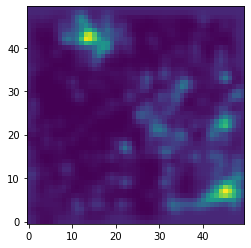

In [8]:
plt.imshow(rd.place_field_data['place_fields'][0], origin='lower')

In [74]:
ripple_ind = 15
ripple_times = rd.data['ripple_times_s'][ripple_ind]
plot_start_time = ripple_times[0]
plot_end_time = ripple_times[1]

spike_ids = rd.data['spike_ids'][(rd.data['spike_times_s'] > plot_start_time) & (rd.data['spike_times_s'] < plot_end_time)]
spike_times = rd.data['spike_times_s'][(rd.data['spike_times_s'] > plot_start_time) & (rd.data['spike_times_s'] < plot_end_time)]

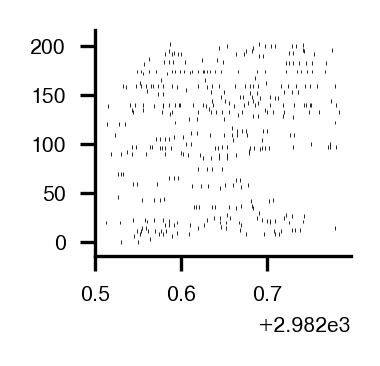

In [75]:
fig, ax = plt.subplots(1,1, figsize=(1.1,1), dpi=300)

for i, pf_id in enumerate(rd.place_field_data['place_cell_ids']):
    pf_spike_times = spike_times[spike_ids == (i)]
    for time in pf_spike_times:
        ax.eventplot([time], lineoffsets=i, orientation="horizontal", linelengths=4, linewidths=.2, color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Spikemat

In [52]:
session = meta.Session_List[0]
spikemat = read_write.load_structure_data(session, 3, 'ripples', 'poisson', 4) 

loading  /home/katharina/Documents/Studium/MIT/project/data/structure_analysis_input/rat1day1_ripples_4cm_3ms_poisson.obj


In [76]:
meta.Session_List[0]

Session_Name(rat=1, day=1)

In [40]:
spikemat.spikemats[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

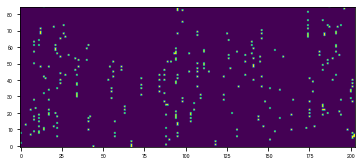

In [73]:
plt.imshow(spikemat.spikemats[15], origin='lower')

## reformat

In [53]:
session = meta.Session_List[0]
reform = read_write.load_structure_data(session,
    3,
    'ripples',
    'poisson',
    bin_size_cm = 4)

loading  /home/katharina/Documents/Studium/MIT/project/data/structure_analysis_input/rat1day1_ripples_4cm_3ms_poisson.obj


In [54]:
model_results = models.Random(reform).get_model_evidences()
model_results

array([ -302.00167991,  -133.8863282 , -1013.66708891,  -113.70324106,
        -275.95047359,  -182.64387076,  -163.70575635,  -491.39313259,
        -346.41669749,  -440.72253742,  -722.07416894,  -360.25601667,
       -1021.45091765,  -564.2809354 ,  -235.33874039,  -987.01262222,
        -371.85749632,  -355.43985313,  -415.98570267,  -792.15899835,
        -229.45363442,  -309.13621193,  -177.87307325,  -474.85881111,
        -188.14417133,  -319.27628825,  -425.70414324,  -318.16709066,
        -133.61510367,  -663.5515326 ,  -221.06345639,  -733.8195656 ,
        -180.8260306 ,  -721.24426118,  -128.90503513,  -537.08250664,
        -549.67788239,  -271.7364171 ,  -216.92386833,  -594.04375062,
        -324.35167867,  -431.62869608,  -654.5859922 ,  -335.7014529 ,
        -127.98784296,  -239.59680221,  -421.9071175 ,  -190.87449636,
        -206.75166243,  -258.76433224,  -618.67782073,  -427.25593805,
        -379.15483029,  -250.45021297,  -725.71465561,  -189.49422   ,
      

## Model Margials

In [55]:
meta.MODELS_AS_STR

['diffusion', 'momentum', 'stationary', 'stationary_gaussian', 'random']

In [57]:
session = meta.Session_List[0]
print(session)
model=meta.MODELS_AS_STR[0]

# load position marginals
spikemat_list = np.arange(24)
ripple_marginals = dict()
for spikemat_ind in spikemat_list:
    ripple_marginals[spikemat_ind] = read_write.load_marginals(
        session, spikemat_ind, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)

rat1day1


FileNotFoundError: [Errno 2] No such file or directory: '/home/katharina/Documents/Studium/MIT/project/1D/results/ripples/rat1day1_spikemat0_4cm_3ms_poisson_marginals.obj'

In [58]:
mar = read_write.load_marginals(
        session, 15, meta.Ripple_Data.default_time_window_ms, meta.Ripple_Data.name, meta.Ripple_Data.default_likelihood_function)

FileNotFoundError: [Errno 2] No such file or directory: '/home/katharina/Documents/Studium/MIT/project/1D/results/ripples/rat1day1_spikemat15_4cm_3ms_poisson_marginals.obj'

In [91]:
mar.marginals['momentum']

array([[0.00000000e+00, 5.57187972e-37, 1.49921209e-38, ...,
        2.92896707e-10, 5.06431397e-10, 5.94140459e-10],
       [0.00000000e+00, 8.08650197e-37, 5.47462927e-39, ...,
        8.54956314e-11, 9.91665708e-11, 1.25282562e-10],
       [0.00000000e+00, 8.73753761e-37, 3.86329859e-39, ...,
        2.57612768e-11, 1.05239055e-11, 1.35718789e-11],
       ...,
       [0.00000000e+00, 6.58565795e-37, 3.94198262e-38, ...,
        3.85228380e-33, 7.76735575e-32, 2.78329979e-31],
       [0.00000000e+00, 6.52096595e-37, 4.16784279e-38, ...,
        3.87115416e-33, 7.89872724e-32, 2.81736562e-31],
       [0.00000000e+00, 6.47894044e-37, 4.10616491e-38, ...,
        3.91094354e-33, 8.00171230e-32, 2.85395546e-31]], dtype=float32)

In [42]:
for model in meta.MODELS_AS_STR:
    plt.imshow(get_marginal_sum(ripple_marginals[1].marginals[model]),
                              aspect='auto', origin='lower', cmap='inferno',vmin=np.log(.001), vmax=np.log(4))
    plt.show()

NameError: name 'ripple_marginals' is not defined